# Open AI gym example
This code shows the use of open AI with chaos theory. Using to explore chaotic control of motors.

Code by Dexter R. Shepherd

### Section 1
Creating the open AI gym simulation

In [42]:
import sys
import gym
import gym
from gym import logger as gymlogger
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import random
from copy import deepcopy as dc

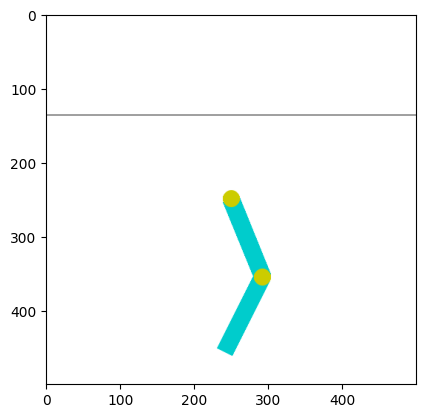

-100.0

In [39]:
genotype=np.zeros((10,))+1
def run_trial(genotype,num_trials,show=True):
    env = gym.make("Acrobot-v1",render_mode="rgb_array")
    observation, info = env.reset()
    rewards=0
    for _ in range(num_trials):
        action = env.action_space.sample()
        action=random.randint(0,2)
        observation, reward, terminated, truncated, info = env.step(action)
        rewards+=reward
        
        if terminated or truncated:
            observation, info = env.reset()
    if show:
        plt.imshow(env.render())
        plt.show()
    env.close()
    return rewards

def visualise(genotype,num_trials):
    env = gym.make("Acrobot-v1",render_mode="rgb_array")
    observation, info = env.reset()
    rewards=0
    for _ in range(num_trials):
        action = env.action_space.sample()
        action=random.randint(0,2)
        observation, reward, terminated, truncated, info = env.step(action)
        rewards+=reward
        plt.imshow(env.render())
        plt.pause(0.05)
        if terminated or truncated:
            observation, info = env.reset()
    env.close()
    return rewards

run_trial(genotype,100)

### Section 2

Chaotic model

Using the Lorenze attractor we have oscilation movement with respect to time (T). 

$\dot{x} = \sigma (y-x)$

$\dot{y} = x ( \rho - z)-y$

$\dot{z} = xy - \beta z$

Three empty numpys of size n are used to store each iteration time step of the lorenze attractor.

$x \in \{0,...,n\},y \in \{0,...,n\},z \in \{0,...,n\}$

$\beta $ represents the geometry factor, aspect ratio of the box. The smaller it is, the more it fits within the sizing. 
$\sigma$ represents the prandtl number - ratio of momentum diffusing. 
$\rho$ represents the rayleigh number - dimentionaless numbe associated with buoyancy-driven flow. 

In 3D we have a chaotic model looking like the following:

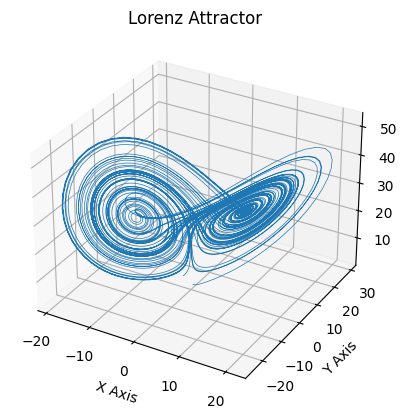

In [16]:
prandtl = 10 
rho = 28
beta = 8/3

def lorenz_attr(x, y, z):
    x_dot = prandtl*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot

dt = 0.01
num_steps = 10000

xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)
xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz_attr(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Plotting this as a 2D plot. By investigating the parameters, it is found that as $\rho < 1$ (0,0,0) is a unique state, but as $\rho > 1$ two steady states bifuricate from the source. This creating the values (for a 2D axis)
$(\pm \sqrt{\beta (\rho - 1)},\pm \sqrt{\beta (\rho - 1)}) $

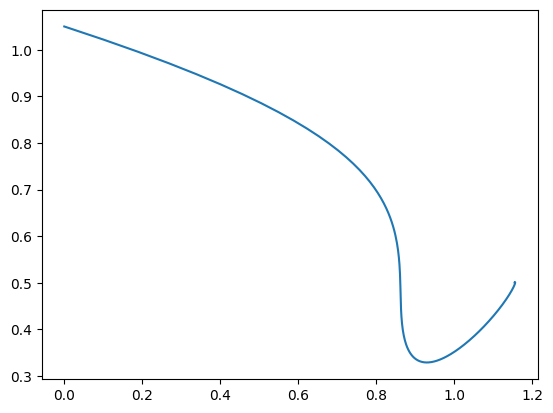

In [17]:
prandtl = 10
rho = 1.5
beta = 8/3

def lorenz_attr(x, y, z):
    x_dot = prandtl*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot

dt = 0.01
num_steps = 10000

xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)
xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz_attr(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

fig = plt.figure()
plt.plot(xs,zs)

plt.show()

Plotting this as the veloicities in each axis

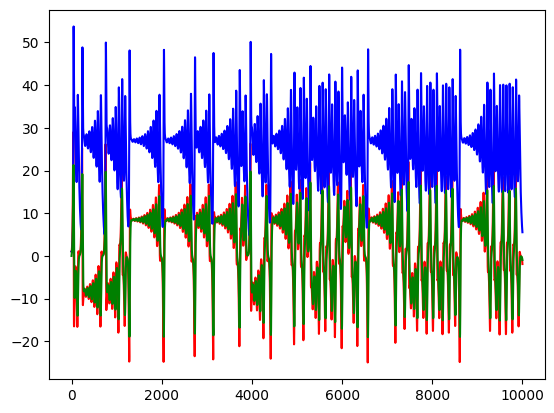

In [19]:
prandtl = 10
rho = 28
beta = 8/3

def lorenz_attr(x, y, z):
    x_dot = prandtl*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot
def get_velocities(prandtl,rho,beta):
    dt = 0.01
    num_steps = 10000

    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)
    xs[0], ys[0], zs[0] = (0., 1., 1.05)

    for i in range(num_steps):
        x_dot, y_dot, z_dot = lorenz_attr(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
    return xs,ys,zs

xs,ys,zs=get_velocities(prandtl,rho,beta)
fig = plt.figure()
plt.plot(ys,c="r")
plt.plot(zs,c="b")
plt.plot(xs,c="g")
plt.show()

Converting the signal from velocities to the state actions of the open ai gym

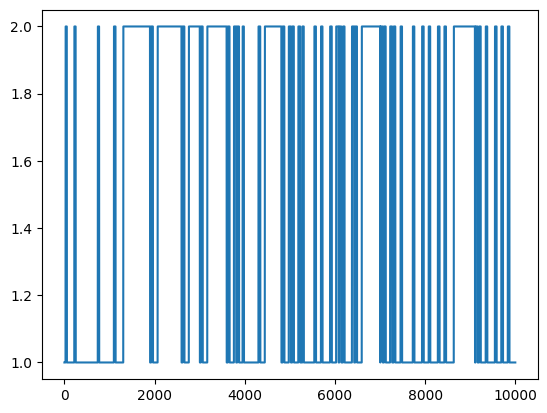

In [25]:
prandtl = 10
rho = 28
beta = 8/3

def convert(signal,val=5):
    signal[signal<(val*-1)]=0
    signal[signal<val]=1
    signal[signal>val]=2
    return signal
xs,ys,zs=get_velocities(prandtl,rho,beta)

#plt.plot(xs,c="g")
plt.plot(convert(xs,val=5))
plt.show()

## Section 3

Using the chaos signals to control the simulation



Reward sum: -100.0


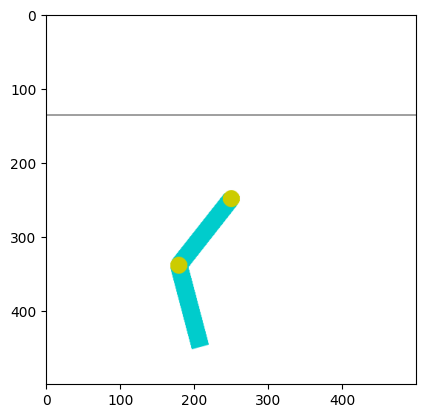

In [45]:
prandtl = 10
rho = 28
beta = 8/3
best=-100
best_chaotic=None
for rho in range(28):
    for prandtl in range(0,100,5):
        xs,ys,zs=get_velocities(prandtl,rho,beta)
        reward=run_trial(xs,100,show=False)
        if reward>=best:
            best=reward
            best_chaotic=dc(xs) #deep copy the genotype
print("Reward sum:",best)
reward=run_trial(best_chaotic,100)
